In [1]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from typing import Set
from nltk.corpus import stopwords
from nltk.tokenize import wordpunct_tokenize
from gensim.models.word2vec import Word2Vec
from gensim.utils import simple_preprocess
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import AgglomerativeClustering

/tmp/ipykernel_34217/922494479.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
!cat data/doc8.txt

Combine oil, lime juice, garlic, oregano, and pepper sauce; pour over steak.
Drain steak, discarding marinade. Sprinkle steak with salt, pepper, and cumin seeds.
Heineken and Carlsberg, two of the world's largest brewers, have reported falling profits after beer sales in western Europe fell flat.
Emmerson’s previous research has shown that residents of Pompeii had a much closer relationship with trash than humans today.
Danish brewer Carlsberg suffered a 3% fall in profits due to waning demand.
Before Mount Vesuvius blanketed Pompeii in volcanic ash, one local’s trash could have easily become another’s building materials.
Heineken increased its dividend payment by 25%.

## Reading content from a text file

In [3]:
with open('data/doc8.txt', 'r') as f:
    text = f.read()

## Creating a text corpus from raw text

In [4]:
corpus = text.split('\n')
corpus

['Combine oil, lime juice, garlic, oregano, and pepper sauce; pour over steak.',
 'Drain steak, discarding marinade. Sprinkle steak with salt, pepper, and cumin seeds.',
 "Heineken and Carlsberg, two of the world's largest brewers, have reported falling profits after beer sales in western Europe fell flat.",
 'Emmerson’s previous research has shown that residents of Pompeii had a much closer relationship with trash than humans today.',
 'Danish brewer Carlsberg suffered a 3% fall in profits due to waning demand.',
 'Before Mount Vesuvius blanketed Pompeii in volcanic ash, one local’s trash could have easily become another’s building materials.',
 'Heineken increased its dividend payment by 25%.']

## Corpus pre-processing

In [5]:
def preprocess_text(text: str, stop_words: Set[str]) -> str:
    text = re.sub(r'[^a-zA-Z\s]', '', text, flags=re.IGNORECASE).lower().strip()
    tokens = wordpunct_tokenize(text)
    filtered_tokens = [t for t in tokens if t not in stop_words]
    return ' '.join(filtered_tokens)

stoplist = set(stopwords.words('english'))
corpus = [preprocess_text(text, stoplist) for text in corpus]
corpus

['combine oil lime juice garlic oregano pepper sauce pour steak',
 'drain steak discarding marinade sprinkle steak salt pepper cumin seeds',
 'heineken carlsberg two worlds largest brewers reported falling profits beer sales western europe fell flat',
 'emmersons previous research shown residents pompeii much closer relationship trash humans today',
 'danish brewer carlsberg suffered fall profits due waning demand',
 'mount vesuvius blanketed pompeii volcanic ash one locals trash could easily become anothers building materials',
 'heineken increased dividend payment']

## Representing a сorpus as a Bag of N-grams Matrix

In [6]:
cv = CountVectorizer(ngram_range=(1, 2))
cv_matrix = cv.fit_transform(corpus)
df = pd.DataFrame(cv_matrix.toarray(), columns=cv.vocabulary_)
df

,combine,oil,lime,juice,garlic,oregano,pepper,sauce,pour,steak,...,easily become,become anothers,anothers building,building materials,increased,dividend,payment,heineken increased,increased dividend,dividend payment
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,1,1,1,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0
5,1,1,1,1,1,1,0,0,1,1,...,1,1,1,1,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
df['profits']

0    0
1    0
2    1
3    0
4    0
5    0
6    0
Name: profits, dtype: int64

## Generating TF-IDF matrix for corpus analysis

In [8]:
tf = TfidfVectorizer(min_df=0., max_df=1., norm='l2', use_idf=True, smooth_idf=True)
tf_matrix = tf.fit_transform(corpus)
pd.DataFrame(np.round(tf_matrix.toarray(), 2), columns=tf.vocabulary_)

,combine,oil,lime,juice,garlic,oregano,pepper,sauce,pour,steak,...,locals,could,easily,become,anothers,building,materials,increased,dividend,payment
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,...,0.27,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,...,0.51,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.27,0.00,0.00,0.27,0.00,0.22,0.0,...,0.00,0.00,0.0,0.00,0.27,0.00,0.00,0.00,0.27,0.27
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.3,...,0.00,0.00,0.3,0.25,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.35,0.00,0.00,0.29,0.0,...,0.00,0.35,0.0,0.00,0.00,0.00,0.00,0.35,0.00,0.00
5,0.26,0.26,0.26,0.00,0.26,0.00,0.00,0.26,0.00,0.0,...,0.00,0.00,0.0,0.22,0.00,0.26,0.26,0.00,0.00,0.00
6,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,...,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00


## Document similarity in corpus

<Axes: >

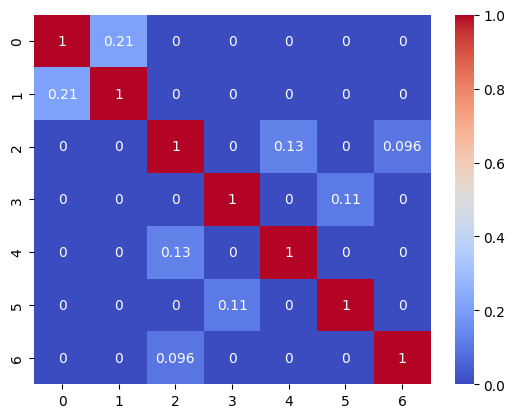

In [9]:
sim_matrix = cosine_similarity(tf_matrix)
sns.heatmap(data=sim_matrix, annot=True, cmap='coolwarm')

## Document Clustering

In [10]:
agg = AgglomerativeClustering(n_clusters=3, metric='euclidean', linkage='ward')
clusters = agg.fit_predict(tf_matrix.toarray())
pd.DataFrame({'Document': corpus, 'Cluster': clusters})

,Document,Cluster
0,combine oil lime juice garlic oregano pepper s...,1
1,drain steak discarding marinade sprinkle steak...,1
2,heineken carlsberg two worlds largest brewers ...,0
3,emmersons previous research shown residents po...,2
4,danish brewer carlsberg suffered fall profits ...,0
5,mount vesuvius blanketed pompeii volcanic ash ...,2
6,heineken increased dividend payment,0


## Preprocessing the corpus

In this case, it is enough to split the sentences into words using '.split(' ')' since the corpus has already been preprocessed with a custom function

In [11]:
corpus = [simple_preprocess(s) for s in corpus]

## Creating a Word2Vec model

In [12]:
w2v_params = {
    'vector_size': 100,
    'window': 5,
    'min_count': 1,
    'sg': 0,
    'workers': 8,
}

w2v = Word2Vec(corpus, **w2v_params)

## Searching for the most similar words

In [13]:
pompeii_ms = w2v.wv.most_similar('pompeii', topn=5)
print('Most similar words to \"pompeii\":\n')
pd.DataFrame(pompeii_ms, columns=['Word', 'Cosine similarity'])

Most similar words to "pompeii":



,Word,Cosine similarity
0,become,0.211943
1,waning,0.201895
2,two,0.199288
3,brewers,0.173181
4,garlic,0.171367


In [14]:
pepper_ms = w2v.wv.most_similar('pepper', topn=5)
print('Most similar words to \"pepper\":\n')
pd.DataFrame(pepper_ms, columns=['Word', 'Cosine similarity'])

Most similar words to "pepper":



,Word,Cosine similarity
0,sales,0.178185
1,dividend,0.163733
2,one,0.149688
3,brewer,0.135264
4,heineken,0.131298
